In [8]:
import MySQLdb
import numpy as np
import pandas as pd
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import Sequential, Model, load_model
from keras.layers import LSTM, Dense, Dropout, GRU, TimeDistributed, Input, merge, Activation
from keras.layers import Reshape
from keras.optimizers import rmsprop, Adamax
from datetime import datetime
import time

import keras.backend as K
from sklearn.preprocessing import MinMaxScaler

# this line tells jupyter notebook to put the plots in the notebook rather than saving them to file.
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('ggplot')

dsn = "mysql://root@localhost:3306/crunchbase"
conn = MySQLdb.connect(host="127.0.0.1", user="root", db="crunchbase")
tables = pd.read_sql("SHOW TABLES", con=conn)

######################################################################################


# We'll use this to adjust for inflation to 2017 USD
filepath = "../inflation.csv"
inflation = pd.read_csv(filepath)

inflation['DATE'] = pd.to_datetime(inflation.DATE)

funding_string = """
SELECT i.funding_round_id, i.investor_object_id, i.funded_object_id, 
f.raised_amount_usd, f.funded_at, f.funding_round_code
FROM cb_funding_rounds as f
INNER JOIN cb_investments as i
ON f.funding_round_id = i.funding_round_id
ORDER BY i.funding_round_id
"""
df_funding = pd.read_sql(funding_string, con=conn)

# Make this a datetime and a little clean up
df_funding['funded_at'] = pd.to_datetime(pd.Series(df_funding['funded_at']))
df_funding['funded_at'] = df_funding.funded_at.apply(lambda x: x.replace(day=1))

# Wayyyy too many funding codes. Let's put them into something a little simpler
df_funding['funding_round_code_clean'] = ['angel' if i == 'angel' else
                                          'seed' if i == 'seed' else
                                          'a' if i == 'a' else
                                          'b' if i == 'b' else
                                          'c' if i == 'c' else
                                          'series_d_above' if i == 'd' else 
                                          'series_d_above' if i == 'e' else 
                                          'series_d_above' if i == 'f' else 
                                          'series_d_above' if i == 'g' else
                                          'series_unknown' if i == 'unattributed' else
                                          'other' if i == 'partial' else 
                                          'other' if i == 'convertible' else 
                                          'other' if i == 'grant' else 
                                          'other' if i == 'crowd' else 
                                          'other' if i == 'debt_round' else
                                          'secondary_market' if i == 'private_equity' else 
                                          'secondary_market' if i == 'post_ipo_debt' else 
                                          'secondary_market' if i == 'post_ipo_equity' else 
                                          'secondary_market' if i == 'secondary_market' else
                                          i for i in df_funding['funding_round_code']]

# Delete the noisy data like 2nd market and other and unknown

# Much better. Let's get rid of this then.
del df_funding['funding_round_code']


# To be combined with a later dataframe
objects_string = """
SELECT id, normalized_name, name, category_code, status, founded_at, closed_at, 
funding_rounds, funding_total_usd FROM cb_objects
"""
df_objects = pd.read_sql(objects_string, con=conn)
df_objects['sector'] = df_objects['category_code']
del df_objects['category_code']

# Let's scale this
df_funding.raised_amount_usd /= df_funding.groupby(['funded_object_id', 
                                                    'funded_at']).raised_amount_usd.transform('count')
# Merging company funding rounds with sector
df_funding_timing = df_funding.merge(df_objects[['id', 'sector']], left_on='funded_object_id', right_on='id')

series_group = df_funding_timing.groupby(['funded_at', 
                                          'funding_round_code_clean',
                                          'sector']).agg({'raised_amount_usd': 'sum'}).unstack().sort_index(1,1)
series_group.columns = series_group.columns.to_series().map('{0[1]}'.format)
df_ = series_group.unstack().iloc[96:]

# Starts at 2005 to 2013 
df_ = df_.apply(lambda x: x.fillna(value=0))


# SNIPPETS OF CODE THAT MIGHT BE USEFUL
# adjusted_high_level = high_level.merge(inflation, left_on='funded_at', right_on='DATE')
# del adjusted_high_level['DATE']
# df_funding_timing['current_USD']=adjusted_high_level.raised_amount_usd*(100/adjusted_high_level.CPIAUCSL_NBD20170101)

In [9]:
df_.columns = df_.columns.to_series().map('{0[0]}_{0[1]}'.format)
df_ = df_.reset_index()

del df_['funded_at']

,funded_at,advertising_a,advertising_angel,advertising_b,advertising_c,advertising_other,advertising_secondary_market,advertising_seed,advertising_series_d_above,advertising_series_unknown,...,travel_series_unknown,web_a,web_angel,web_b,web_c,web_other,web_secondary_market,web_seed,web_series_d_above,web_series_unknown
0,2005-01-01,24500000.0,0.0,0.0,0.0,0.0,0.0,1100000.0,0.0,4500000.0,...,0.0,11500000.0,300000.0,0.0,0.0,0.0,0.0,0.0,0.0,14500000.0
1,2005-02-01,16500000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,5600000.0,0.0,14000000.0,0.0,5000000.0,0.0,0.0,0.0,0.0
2,2005-03-01,2000000.0,0.0,0.0,8000000.0,0.0,0.0,0.0,0.0,0.0,...,0.0,6600000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2005-04-01,2900000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12000000.0,...,0.0,7500000.0,600000.0,7000000.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2005-05-01,1000000.0,0.0,28500000.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,7100000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
#K._BACKEND == 'tensorflow'

def custom_r2(y_true, y_pred):
    baseline = K.sum((y_true - K.mean(y_true))**2)
    model_fit = K.sum((y_true - y_pred)**2)
    return 1. - model_fit/baseline

#Scale data between 0,1 for LSTM/GRU
# MMS = MinMaxScaler()
df = pd.DataFrame(np.log1p(df_), columns=df_.columns)

#  Remember to shift the data so we are predicting one time step future
X = df.iloc[:-1,:]
y = df.iloc[1:,-378:] #263 locationIDs

train_size = .97

# Train-Test-Split-80/20
X_train, X_test = X[:int(round(len(X)*train_size, 0))], X[int(round(len(X)*train_size, 0)):]
y_train, y_test = y[:int(round(len(y)*train_size, 0))], y[int(round(len(y)*train_size, 0)):]

#Reshape for LSTM/GRU layers
Xtr = X_train.values.reshape((1, X_train.shape[0], X_train.shape[1]))
ytr = y_train.values.reshape((1, y_train.shape[0], y_train.shape[1]))
Xte = X_test.values.reshape((1, X_test.shape[0], X_test.shape[1]))
yte = y_test.values.reshape((1, y_test.shape[0], y_test.shape[1]))

# Trying a different shape
Xtr = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
ytr = np.reshape(y_train, (y_train.shape[0], y_train.shape[1], 1))
Xte = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
yte = np.reshape(y_test, (y_test.shape[0], y_test.shape[1], 1))
                 
#Check data validity
# print len(X_train) + len(X_test), len(y_train) + len(y_test)
X_train.head()

,advertising_a,advertising_angel,advertising_b,advertising_c,advertising_other,advertising_secondary_market,advertising_seed,advertising_series_d_above,advertising_series_unknown,analytics_a,...,travel_series_unknown,web_a,web_angel,web_b,web_c,web_other,web_secondary_market,web_seed,web_series_d_above,web_series_unknown
0,17.014184,0.0,0.000000,0.000000,0.0,0.0,13.910822,0.0,15.319588,13.592368,...,0.0,16.257858,12.611541,0.000000,0.0,0.000000,0.0,0.0,0.0,16.489659
1,16.618871,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,15.538277,0.000000,16.454568,0.0,15.424949,0.0,0.0,0.0,0.000000
2,14.508658,0.0,0.000000,15.894952,0.0,0.0,0.000000,0.0,0.000000,15.687313,...,0.0,15.702580,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000
3,14.880222,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,16.300417,0.000000,...,0.0,15.830414,13.304687,15.761421,0.0,0.000000,0.0,0.0,0.0,0.000000
4,13.815512,0.0,17.165415,0.000000,0.0,0.0,0.000000,0.0,0.000000,16.705882,...,0.0,15.775605,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000


In [29]:
def build_model(n_features, dropout, n_outputs, compile_model=1, load_weights=0, loss='mse', lr=0.01):
    '''
    Builds a n-Layer neural_network 
    
    Parmaters
    ---------
    
    '''
    model = Sequential()

    #DENSE - INPUT
    model.add(TimeDistributed(Dense(256, activation='relu'), input_shape=(None, n_features)))
    model.add(Dropout(dropout))
    
    #DENSE (2 Layers)
    model.add(TimeDistributed(Dense(256, activation='relu')))
    model.add(Dropout(dropout))
    model.add(TimeDistributed(Dense(256, activation='relu')))
    model.add(Dropout(dropout))

    #LSTM (1 Layers)
    model.add(LSTM(256, return_sequences=True))
    model.add(Dropout(dropout))


    #DENSE (2 Layers)
    model.add(TimeDistributed(Dense(256, activation='relu')))
    model.add(Dropout(dropout))
    model.add(TimeDistributed(Dense(256, activation='relu')))
    model.add(Dropout(dropout))

    # LSTM (1 Layer)
    model.add(LSTM(256, return_sequences=True))
    model.add(Dropout(dropout))

    # DENSE (2 Layers)
    model.add(TimeDistributed(Dense(256, activation='relu')))
    model.add(Dropout(dropout))
    model.add(TimeDistributed(Dense(256, activation='relu')))
    model.add(Dropout(dropout))
    
    #OUTPUT
    model.add(TimeDistributed(Dense(n_outputs, activation='relu')))

    if compile_model == 1:
        model.compile(loss=loss, optimizer=Adamax(lr=lr), metrics=[custom_r2])

    if load_weights == 1:
        model.load_weights('/Users/anniebarry/DSI-SF-6/Capstone'+file_name+'.h5')
        
    return model
    
    
def run_neural_network(model, Xtr, ytr, Xte, yte, n_epochs, batch_size=1, verbose=0, save_weights=0):
    '''
    Runs neural_network.

    Parameters
    ----------
    '''
#     try: 
    start_time = time.time()
    print 'Executing ||', str(datetime.now()) 

    history = model.fit(Xtr, ytr, validation_data=(Xte, yte),
              batch_size=12, verbose=verbose, nb_epoch=n_epochs, shuffle=False)

    print 'Execution_Complete || Runtime w/', n_epochs, 'epochs =', round((time.time() - start_time)/60., 2), 'minutes'

    if save_weights == 1:
        save_unit_weights()

    return history
#     except KeyboardInterrupt:
#         pass
#     except:
#         print '--Error in running model---'
    
    
def save_unit_weights():
    '''
    Saves weights of previously run neural_network.

    Parameters
    ----------
    '''
    file_name = str(datetime.now()).replace(':', '_').replace(' ','_')[:19]
    model.save_weights('/Users/anniebarry/DSI-SF-6/Capstone'+file_name+'.h5', overwrite=True)
    print 'Saved ||', str(datetime.now())
    
    
def plot_neural_net_results(history, limit_r2=0, save_results=0):
    '''
    Plots results of neural network.

    Parameters
    ----------
    '''
    results = pd.DataFrame(history.history)

    # SUMMARY RESULTS
    print '---MAX RESULTS--- \n', results[['custom_r2','val_custom_r2']].iloc[:].max(), '\n'
    print '---TAIL RESULTS--- \n', results[['custom_r2','val_custom_r2']].iloc[-1:], '\n'

    # Build figure
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12,4.5))

    # Assign Axis Plots
    ax0.plot(results[['custom_r2', 'val_custom_r2']].iloc[:])
    ax1.plot(results[['loss', 'val_loss']].iloc[:])

    # Add horizontal and vertical line for max
    ax0.axhline(results['val_custom_r2'].max(), color='red', lw=0.5)
    ax0.axvline(results['val_custom_r2'].idxmax(), color='red', lw=0.5)

    #Set axis limits
    if limit_r2 == 1:
        ax0.set_ylim(bottom=0.5, top=0.6)

    # Rename axis titles
    ax0.set_title('r2', fontsize=15)
    ax1.set_title('loss', fontsize=15)

    #ax0.legend(loc='lower right')

    # Show plots
    plt.show()

    if save_results == 1:
        file_name = str(datetime.now()).replace(':', '_').replace(' ','_')[:19]
        results.to_csv('/Users/anniebarry/DSI-SF-6/Capstone'+ file_name + '.csv')


Executing || 2017-05-31 12:31:18.330925
Train on 1 samples, validate on 1 samples
Epoch 1/100
1/1 [==============================] - 3s - loss: 65.3910 - custom_r2: -0.3331 - val_loss: 97.2262 - val_custom_r2: -0.5793
Epoch 2/100
1/1 [==============================] - 0s - loss: 64.5859 - custom_r2: -0.3167 - val_loss: 96.7992 - val_custom_r2: -0.5724
Epoch 3/100
1/1 [==============================] - 1s - loss: 63.1950 - custom_r2: -0.2883 - val_loss: 96.0991 - val_custom_r2: -0.5610
Epoch 4/100
1/1 [==============================] - 1s - loss: 61.6163 - custom_r2: -0.2561 - val_loss: 95.0629 - val_custom_r2: -0.5442
Epoch 5/100
1/1 [==============================] - 1s - loss: 59.7525 - custom_r2: -0.2181 - val_loss: 93.6203 - val_custom_r2: -0.5207
Epoch 6/100
1/1 [==============================] - 1s - loss: 57.9317 - custom_r2: -0.1810 - val_loss: 91.7224 - val_custom_r2: -0.4899
Epoch 7/100
1/1 [==============================] - 1s - loss: 56.3371 - custom_r2: -0.1485 - val_loss:

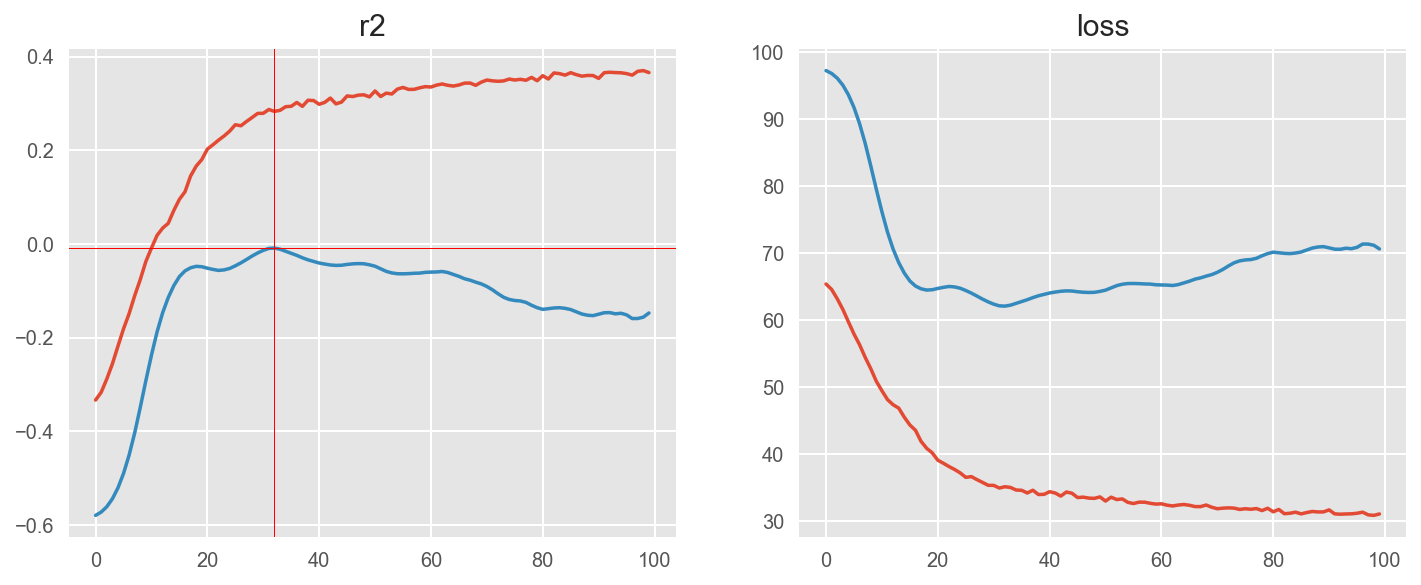

In [30]:
#1 - Build that Model
model = build_model(n_features=Xtr.shape[2], dropout=0.5, n_outputs=378, compile_model=1, load_weights=0, lr=0.001)

#2 - Run Model
history = run_neural_network(model=model, Xtr=Xtr, ytr=ytr, Xte=Xte, yte=yte, save_weights=0, verbose=1, n_epochs=100)

#3 - Plot Model
plot_neural_net_results(history, save_results=0)

###### 